In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 1
set_seed(seed)

# **1. Sentiment Analysis for Financial News**

# **Data**

In [3]:
data_path = '/kaggle/input/aio-datasets/module6 - w3 - dataset/all-data.csv'
df = pd.read_csv(data_path, names=['sentiment', 'content'], encoding='ISO-8859-1')
df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [4]:
class_dict = {class_name : idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
class_dict

{'neutral': 0, 'negative': 1, 'positive': 2}

In [5]:
class_dict['neutral']

0

In [6]:
df['sentiment'] = df['sentiment'].apply(lambda x: class_dict[x])
df

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


***Preprocessing data***

In [7]:
import nltk
from nltk.stem.porter import PorterStemmer
import string
import re

In [8]:
# preprocessing: remove stopword, punctuation, lowercase, steaming
def preprocessing(text, stemmer):
    punc = string.punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', punc))
    new_text = []
    stopwords = nltk.corpus.stopwords.words('english')
    for word in text.split(' '):
        if word in stopwords:
            new_text.append('')
        else:
            new_text.append(stemmer.stem(word))
           
    return " ".join(new_text)

In [9]:
df['content'] = df['content'].apply(lambda x: preprocessing(x, PorterStemmer()))

In [10]:
vocab = ['UNK', 'PAD']
for li in df['content'].tolist():
    words = li.split()
    for w in words:
        if w not in vocab:
            vocab.append(w)
vocab_dict = {word: idx for idx, word in enumerate(vocab)}
print(len(vocab_dict))

8914


In [11]:
def word_to_number(sequence, seq_length, vocab_dict):
    words = sequence.split()
    index_vector = []
    for word in words:
        try:
            index_vector.append(vocab_dict[word])
        except:
            index_vector.append(vocab_dict['UNK'])
    if len(words) < seq_length:
        for i in range(len(words), seq_length):
            index_vector.append(vocab_dict['PAD'])
    else:
        index_vector = index_vector[:seq_length]
    return index_vector

***prepare data for training***

In [12]:
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

In [13]:
train_text, test_text, train_label, test_label = train_test_split(texts, labels, test_size=0.2, 
                                                                  random_state=seed, shuffle=True)
valid_text, test_text, valid_label, test_label = train_test_split(test_text, test_label, test_size=0.5, 
                                                                  random_state=seed, shuffle=True)

In [14]:
class FinancialNew(Dataset):
    def __init__(self, sequences, labels, 
                 seq_length, vocab_dict, 
                 transform=None):
        self.sequences = sequences
        self.labels = labels
        self.seq_length = seq_length
        self.vocab_dict = vocab_dict
        self.transform = transform

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        word_vectors = self.transform(sequence, self.seq_length, self.vocab_dict)
        word_vectors = torch.tensor(word_vectors)
        label = self.labels[idx]
        return word_vectors, label


In [15]:
seq_length = 32
train_dataset = FinancialNew(train_text, train_label, 
                         seq_length=seq_length, vocab_dict=vocab_dict, 
                         transform=word_to_number)

valid_dataset = FinancialNew(valid_text, valid_label, 
                         seq_length=seq_length, vocab_dict=vocab_dict, 
                         transform=word_to_number)

test_dataset = FinancialNew(test_text, test_label, 
                         seq_length=seq_length, vocab_dict=vocab_dict, 
                         transform=word_to_number)

In [16]:
train_batch_size = 64
test_batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# **Model: RNN**

In [17]:
!pip install torchsummary
from torchsummary import summary

In [18]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, n_classes, dropout_rate=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)
        

    def forward(self, x):
        x = x.type(torch.LongTensor) #input of Embedding must be LongTensor or Int
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :] # get final word
        x = self.flatten(x)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [19]:
embedding_dim = 64
hidden_dim = 64
num_layers = 2
vocab_size = len(vocab)
n_classes = len(class_dict)
dropout_rate=0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentimentClassifier(vocab_size, embedding_dim, 
                            hidden_dim, num_layers, 
                            n_classes, dropout_rate).to(device)

In [20]:
summary(model, (50, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 50, 64]         570,496
               RNN-2  [[-1, 50, 64], [-1, 2, 64]]               0
           Flatten-3                   [-1, 64]               0
         LayerNorm-4                   [-1, 64]             128
           Dropout-5                   [-1, 64]               0
            Linear-6                   [-1, 16]           1,040
              ReLU-7                   [-1, 16]               0
            Linear-8                    [-1, 3]              51
Total params: 571,715
Trainable params: 571,715
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.10
Params size (MB): 2.18
Estimated Total Size (MB): 5.28
----------------------------------------------------------------


***Training***

In [21]:
def compute_accucary(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)
    return np.sum(predicted == labels) * 100 / predicted.shape[0]

In [22]:
def train_one_epoch(train_loader, valid_loader, 
                    model, device, 
                    loss_func, optimizer):
    model.train()
    train_batch_loss = 0.0
    train_labels = []
    train_preds = []
    
    for i, (train_imgs, batch_train_labels) in enumerate(train_loader):
        train_imgs = train_imgs.to(device)
        batch_train_labels = batch_train_labels.to(device)
        optimizer.zero_grad()
        outputs = model(train_imgs)
        train_loss = loss_func(outputs, batch_train_labels)
        train_batch_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        train_preds += (outputs.argmax(dim=1).cpu().tolist())
        train_labels += (batch_train_labels.cpu().tolist())
        
    
    avg_batch_loss = train_batch_loss / len(train_loader)
    train_accuracy_score = compute_accucary(train_preds, train_labels)
    
    return avg_batch_loss, train_accuracy_score

In [23]:
# training
import time

def train(train_loader, valid_loader, model, device, num_epochs, loss_func, optimizer):
    max_valid_acc = 0.0
    
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        avg_train_loss,  train_accuracy_score = train_one_epoch(train_loader, valid_loader, 
                                                                model, device, 
                                                                loss_func, optimizer)
    
        # evaluate
        model.eval()
        valid_batch_loss = 0.0
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for valid_imgs, batch_valid_labels in valid_loader:
                valid_imgs = valid_imgs.to(device)
                batch_valid_labels = batch_valid_labels.to(device)
                predicted = model(valid_imgs)
                val_loss = loss_func(predicted, batch_valid_labels)
                valid_batch_loss += val_loss.item()
                valid_preds += (predicted.argmax(dim=1).cpu().tolist())
                valid_labels += (batch_valid_labels.cpu().tolist())
    
        avg_valid_loss = valid_batch_loss / len(valid_loader)
        valid_accuracy_score = compute_accucary(valid_preds, valid_labels)
    
        # save log
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_accuracies.append(train_accuracy_score)
        valid_accuracies.append(valid_accuracy_score)
        
        #save best model
        if max_valid_acc < valid_accuracy_score:
            max_valid_acc = valid_accuracy_score
            print(f'save best model at epoch {epoch+1}')
            torch.save(model.state_dict(), './best_model.pt')
        # print log
        print(f"Epoch {epoch+1}/{num_epochs} | {time.time() - start_time}s:")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy_score:.2f}% | Valid Loss: {avg_valid_loss:.4f} | Valid Accuracy: {valid_accuracy_score:.2f}%")
        print('-------------------------------------------------------------------------------------------')
    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [24]:
# define hyperparameters

num_epochs = 50
lr = 1e-4
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, valid_losses, train_accuracies, valid_accuracies = train(train_loader, valid_loader, 
                                                                       model, device, num_epochs, 
                                                                       loss_func, optimizer)

save best model at epoch 1
Epoch 1/50 | 1.45955491065979s:
Train Loss: 0.9900 | Train Accuracy: 53.90% | Valid Loss: 0.9372 | Valid Accuracy: 57.32%
-------------------------------------------------------------------------------------------
save best model at epoch 2
Epoch 2/50 | 1.4012606143951416s:
Train Loss: 0.9296 | Train Accuracy: 59.34% | Valid Loss: 0.9359 | Valid Accuracy: 57.53%
-------------------------------------------------------------------------------------------
Epoch 3/50 | 1.387570858001709s:
Train Loss: 0.9292 | Train Accuracy: 59.47% | Valid Loss: 0.9281 | Valid Accuracy: 57.53%
-------------------------------------------------------------------------------------------
Epoch 4/50 | 1.4330284595489502s:
Train Loss: 0.9307 | Train Accuracy: 59.39% | Valid Loss: 0.9459 | Valid Accuracy: 57.53%
-------------------------------------------------------------------------------------------
Epoch 5/50 | 1.3697192668914795s:
Train Loss: 0.9277 | Train Accuracy: 59.47% | Valid

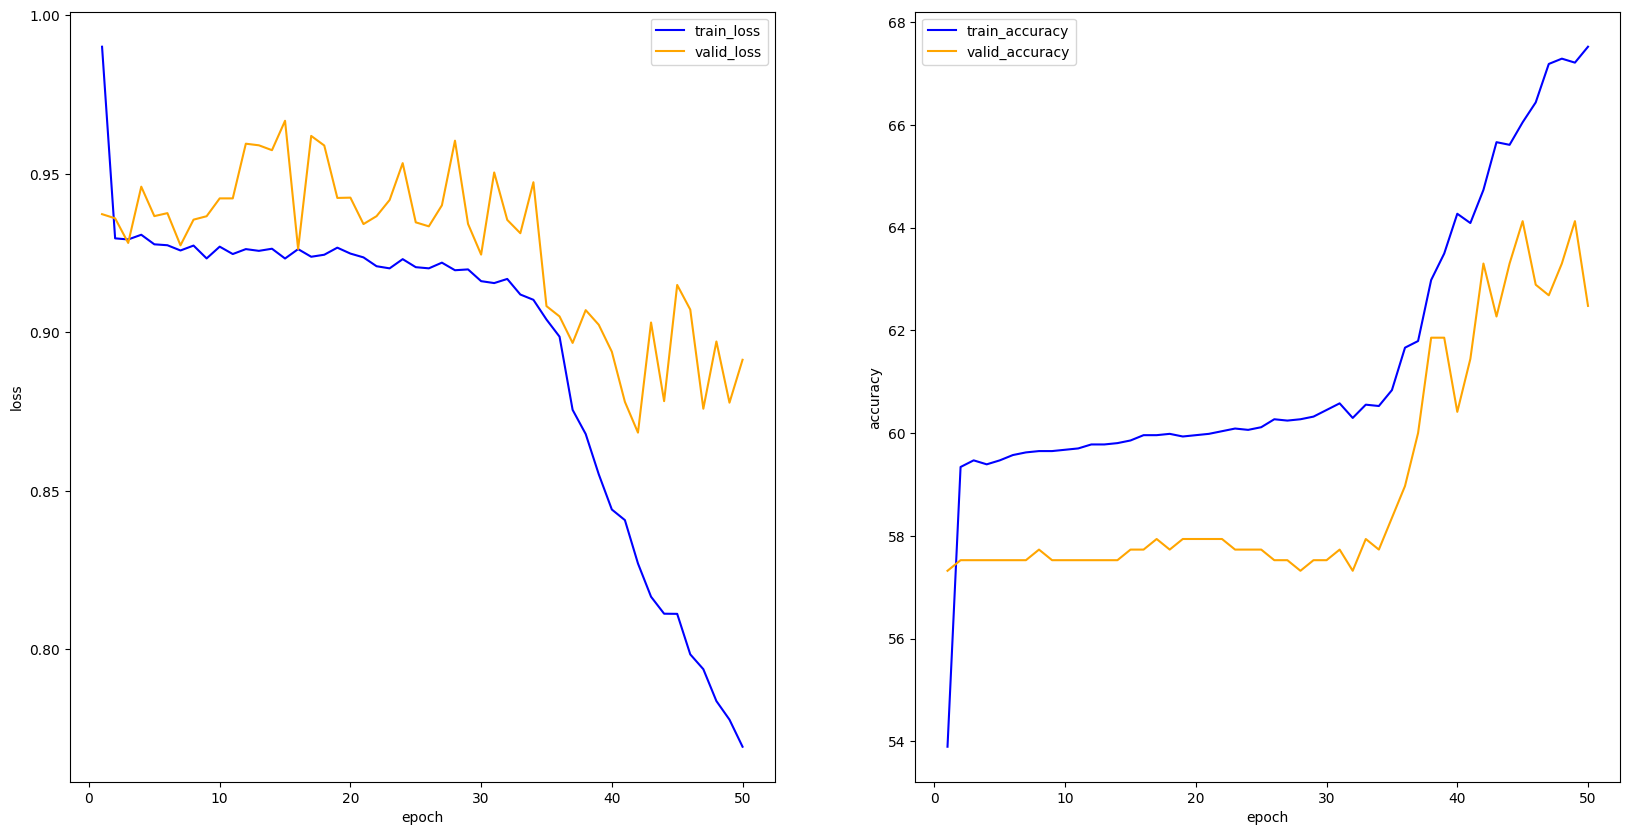

In [25]:
# Plot log
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='train_loss', color='blue')
ax[0].plot(range(1, len(valid_losses) + 1), valid_losses, label='valid_loss', color='orange')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train_accuracy', color='blue')
ax[1].plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='valid_accuracy', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

# **Loading best model and testing**

In [26]:
embedding_dim = 64
hidden_dim = 64
num_layers = 2
vocab_size = len(vocab)
n_classes = len(class_dict)
dropout_rate=0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentimentClassifier(vocab_size, embedding_dim, 
                            hidden_dim, num_layers, 
                            n_classes, dropout_rate).to(device)
model.load_state_dict(torch.load('./best_model.pt', weights_only=True))

<All keys matched successfully>

In [27]:
# Testing
model.eval()
test_batch_loss = 0.0
test_labels = []
test_preds = []
with torch.no_grad():
    for test_imgs, batch_test_labels in test_loader:
        test_imgs = test_imgs.to(device)
        batch_test_labels = batch_test_labels.to(device)
        predicted = model(test_imgs)
        test_loss = loss_func(predicted, batch_test_labels)
        test_batch_loss += test_loss.item()
        test_preds += (predicted.argmax(dim=1).cpu().tolist())
        test_labels += (batch_test_labels.cpu().tolist())

avg_test_loss = test_batch_loss / len(test_loader)
test_accuracy_score = compute_accucary(test_preds, test_labels)

print(f"Test_loss: {avg_test_loss}")
print(f"Test_acc: {test_accuracy_score}")

Test_loss: 0.8457894138991833
Test_acc: 61.855670103092784
